`yellow_tripdata_2017-05.csv` contains approx 10 million lines. 850MB.
`head -n 1 ../data/yellow_tripdata_2017-05.csv > yellow_tripdata_2017-05-small.csv;
tail -n +3 ../data/yellow_tripdata_2017-05.csv | shuf -n 10000 >> yellow_tripdata_2017-05-small.csv` to get 10000 random lines.

Cols = zip (categorical), hour (0 <= * <= 23), day (0 <= * <= 6), temperature in F, hourly precipitation in inch

The script creates `yellow_counts_201405.csv` and `weather_201405.csv`. TODO: these should be joined?
Zip codes in `yellow_counts_201405.csv` were obtained from the `uszipcode` package. Its integrity is questionable. See 'Debug missing zips' section. Should rerun zip code generation with Nominatim.

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime

## Taxi data
Convert (lat, lon) to zip code.

Questions. 
1. Taxi datetime in EST or UTC? -> probably EST.
2. Daylight saving time?

In [141]:
# Note: column names have changed.
# TODO: Taxi datetime in EST or UTC?
#   'PULocationID' instead of 'pickup_datetime' and 'pickup_latitude' for newer data.
yellow_raw = pd.read_csv("yellow_tripdata_2014-05-small.csv")
yellow_raw.columns = [c.replace(" ", "") for c in yellow_raw.columns] # remove space in column name
yellow_raw.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2014-05-07 09:33:52,2014-05-07 09:52:36,1,1.80,-73.977133,40.747167,1,N,-73.981178,40.765351,CRD,12.5,0.0,0.5,2.60,0.0,15.60
1,VTS,2014-05-17 22:59:00,2014-05-17 23:09:00,1,2.79,-73.972897,40.743702,1,NaN,-73.987187,40.722415,CRD,11.0,0.5,0.5,0.00,0.0,12.00
2,VTS,2014-05-10 01:14:00,2014-05-10 01:23:00,2,2.60,-73.947613,40.775355,1,NaN,-73.975252,40.751955,CRD,10.0,0.5,0.5,2.62,0.0,13.62
3,CMT,2014-05-19 19:33:02,2014-05-19 19:36:39,1,0.80,-73.992872,40.743114,1,N,-73.993951,40.749203,CRD,5.0,1.0,0.5,1.62,0.0,8.12
4,CMT,2014-05-10 16:43:45,2014-05-10 16:53:36,3,1.80,-73.951445,40.793820,1,N,-73.958757,40.809735,CSH,9.0,0.0,0.5,0.00,0.0,9.50


In [142]:
# converts the date format in the rides raw data to Year-Month-Day-Hour.
def format_rides_date(d):
    dt = datetime.strptime(d, '%Y-%m-%d %H:%M:%S')
    return datetime.strftime(dt, '%Y-%m-%d-%H')

In [143]:
yellow = yellow_raw.loc[:,['pickup_datetime', 'pickup_latitude', 'pickup_longitude']]
yellow.columns = ['date', 'lat', 'lon']
yellow['type'] = "yellow"
# keep the date and hour.
yellow.loc[:,'date'] = pd.to_datetime(yellow['date'], \
        format='%Y-%m-%d %H:%M:%S')
yellow.head()

,date,lat,lon,type
0,2014-05-07 09:33:52,40.747167,-73.977133,yellow
1,2014-05-17 22:59:00,40.743702,-73.972897,yellow
2,2014-05-10 01:14:00,40.775355,-73.947613,yellow
3,2014-05-19 19:33:02,40.743114,-73.992872,yellow
4,2014-05-10 16:43:45,40.793820,-73.951445,yellow


## Bucket coordinates into geographical units
Census Tract (CT) is the most granular. Neighborhood Tabulation Areas (NTA) more coarse. CTs are proper subsets of NTA. Is NTA the same as Zip Code Tabulation Area?
Neither ZIP nor NTA is a subset of the other. The two are similar.
CT might be too fine; there might not be enough data points in each bucket; might be too computationally expensive.

Nominatim Docker approach.
Get PBF from here https://download.geofabrik.de/north-america/us/new-york.html . Takes 9 hours.
Import TIGER data to use census tract http://nominatim.org/release-docs/latest/admin/Import-and-Update/#installing-tiger-housenumber-data-for-the-us

PostGIS approach for census tract. Feel like too much low-level work.
Geo data: https://www.census.gov/geo/maps-data/
-> get TIGER geodatabases 2017 New York state level
In postgres user: `createdb tigergdb`, then `ogr2ogr -f "PostgreSQL" PG:"dbname=tigergdb user=postgres" tlgdb_2017_a_36_ny.gdb` from a usual user.
See https://gis.stackexchange.com/a/21544 , 

In [106]:
from uszipcode import ZipcodeSearchEngine
search = ZipcodeSearchEngine()

In [144]:
query_result = yellow.loc[:,('lat','lon')].apply(lambda row: \
    search.by_coordinate(row['lat'], row['lon'], radius=1,returns=1) , axis=1)
zips = query_result.apply(lambda z: z[0]['Zipcode'] if len(z) > 0 else 'missing')
zips.name = 'zip'
yellow_with_zip = yellow.loc[:,('date','type')].join(zips)
yellow_with_zip.head(10)

,date,type,zip
0,2014-05-07 09:33:52,yellow,10016
1,2014-05-17 22:59:00,yellow,10016
2,2014-05-10 01:14:00,yellow,10028
3,2014-05-19 19:33:02,yellow,10119
4,2014-05-10 16:43:45,yellow,10029
5,2014-05-22 22:37:00,yellow,10173
6,2014-05-12 23:04:50,yellow,11371
7,2014-05-13 20:56:21,yellow,10010
8,2014-05-13 09:30:00,yellow,10023
9,2014-05-06 10:08:46,yellow,10119


### Debug missing zips
`uszipcode` integrity fishy.
`sum(zips == 'missing')` -> 277 for radius=1; 268 for radius=2, most of which are accounted for by lat == 0.00; more than 1000 for radius=0.5.

In [108]:
sum(zips == 'missing')

277

In [109]:
yellow_debug = yellow.join(zips)

In [110]:
yellow_debug[(yellow_debug['zip'] == 'missing') & (yellow_debug['lat'] != 0.00)]

,date,lat,lon,type,zip
909,2014-05-15-20,40.685568,-73.994543,yellow,missing
1812,2014-05-15-23,39.518332,-73.526515,yellow,missing
2140,2014-05-19-16,40.655015,-73.807480,yellow,missing
2365,2014-05-11-14,41.209370,-74.215965,yellow,missing
3199,2014-05-03-00,40.724664,-73.935573,yellow,missing
4068,2014-05-06-16,40.764680,-74.047600,yellow,missing
5129,2014-05-07-13,40.652873,-73.806602,yellow,missing
7362,2014-05-25-22,40.681903,-73.993789,yellow,missing
7693,2014-05-17-01,40.724128,-73.587668,yellow,missing
8442,2014-05-17-12,40.636147,-73.967763,yellow,missing


In [111]:
# Result wrong.
search.by_coordinate(40.685568,-73.994543, radius=2)[0]['Zipcode']

'11217'

In [112]:
#sum(yellow_with_zip['zip'] == 'missing') # -> 277

## Weather data
Station ID = GHCND:USW00094728
There are other stations nearby (

Data source (i): NEWA http://newa.cornell.edu/index.php?page=hourly-weather ; Data not in a nice format. The data shown on their interface has time difference from data retrieved via their REST API.
Use `curl -XPOST "http://data.nrcc.rcc-acis.org/StnData" -H "Content-Type: application/json" -d'
{"params":{"sid":"knyc icao","sdate":"2014-05-01","edate":"2014-05-31","elems":[{"vX":23,"prec":1},{"vX":22},{"vX":5},{"vX":24},{"vX":28,"prec":1},{"vX":27}],"meta":"tzo"}} ' > nyc-centralpark-hourly-precip-2014-05.json`
to get data from 2014-05-01 to 2014-05-31

Data source (ii): NCDC NOAA. Hourly precipitation data limited to before 2014.

Data source (iii): Iowa Environmental Mesonet (hourly precipitation only) https://mesonet.agron.iastate.edu/request/asos/hourlyprecip.phtml?network=NY_ASOS ; stations NYC, LGA. (Some historical data not available from JRB - wall street)

Data source (iv): IEM METAR data https://mesonet.agron.iastate.edu/request/download.phtml?network=NY_ASOS ; use LGA. Contains both temperature (F) and precip (inch). Observation not made at round hours -> group by hour and take average. Precipitation data (p01i) recorded at the 51st minute of every hour; values are roughly equal with those obtained from Mesonet (data source iii).

### Mesonet precipitation data
The dataframe not used. Code kept for record.

In [113]:
precip_mesonet_raw = pd.read_csv("nyc-2014-05-precip-hourly.csv")
precip_mesonet = precip_mesonet_raw.loc[:, ('valid', 'precip_in')]
precip_mesonet.columns = ['date', 'precip_in']
precip_mesonet['date'] = precip_mesonet['date'].str[0:13].replace("\s+", "-", regex=True)
precip_mesonet = precip_mesonet.set_index('date')

In [114]:
print(precip_mesonet.describe())
precip_mesonet.head()

        precip_in
count  766.000000
mean     0.012311
std      0.062363
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


,precip_in
date,
2014-04-30-01,0.03
2014-04-30-02,0.13
2014-04-30-03,0.11
2014-04-30-04,0.11
2014-04-30-05,0.03


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9bab28c240>]],
      dtype=object)

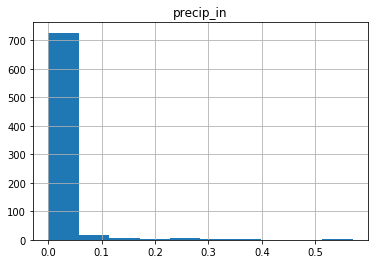

In [115]:
precip_mesonet[precip_mesonet["precip_in"] < 1].hist()

### Metar data

In [116]:
metar_raw = pd.read_csv("lga-2014-05-metar.csv")
metar_raw.columns = [name.strip() for name in metar_raw.columns]
metar_raw.head()

,station,valid,tmpf,sped,p01i
0,LGA,2014-05-01 00:24,48.20,12.7,0.00
1,LGA,2014-05-01 00:51,48.92,12.7,0.30
2,LGA,2014-05-01 01:31,53.60,4.6,0.03
3,LGA,2014-05-01 01:42,53.60,6.9,0.00
4,LGA,2014-05-01 01:51,53.96,5.8,0.08


In [117]:
# converts the date format in the metar raw data to Year-Month-Day-Hour.
def format_metar_date(d):
    dt = datetime.strptime(d, '%Y-%m-%d %H:%M')
    return datetime.strftime(dt, '%Y-%m-%d-%H')

In [118]:
# rename columns. Keep minutes 
metar = metar_raw.loc[:, ('valid', 'tmpf', 'p01i')] # precip_in in 'p01i'
metar.columns = ['date', 'fahrenheit', 'precip_in']
metar.loc[:,'date'] = metar['date'].apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M'))
metar.head()

,date,fahrenheit,precip_in
0,2014-05-01 00:24:00,48.20,0.00
1,2014-05-01 00:51:00,48.92,0.30
2,2014-05-01 01:31:00,53.60,0.03
3,2014-05-01 01:42:00,53.60,0.00
4,2014-05-01 01:51:00,53.96,0.08


In [119]:
precip = metar[['date','precip_in']]
precip = precip[precip['date'].apply(lambda d: d.minute) == 51]
precip.loc[:,'date'] = precip['date'].apply(lambda d: datetime.strftime(d, '%Y-%m-%d-%H'))
precip.head()

,date,precip_in
1,2014-05-01-00,0.30
4,2014-05-01-01,0.08
6,2014-05-01-02,0.06
8,2014-05-01-03,0.01
10,2014-05-01-04,0.01


In [120]:
# take the mean of temperature records in each hour.
metar.loc[:,'date'] = metar['date'].apply(lambda d: datetime.strftime(d, '%Y-%m-%d-%H'))
fahrenheit_averaged = metar.loc[:,['date','fahrenheit']].groupby(['date']).mean()
fahrenheit_averaged.head()

,fahrenheit
date,
2014-05-01-00,48.56
2014-05-01-01,53.72
2014-05-01-02,53.78
2014-05-01-03,55.22
2014-05-01-04,55.22


In [121]:
weather_201405 = precip.set_index('date').join(fahrenheit_averaged, how='inner')
weather_201405.head()

,precip_in,fahrenheit
date,,
2014-05-01-00,0.30,48.56
2014-05-01-01,0.08,53.72
2014-05-01-02,0.06,53.78
2014-05-01-03,0.01,55.22
2014-05-01-04,0.01,55.22


In [122]:
weather_201405.isna().sum() # => 0 for how='outer'; same for 'inner'
weather_201405.shape # (744,2) for how='outer'; same for 'inner'

(744, 2)

### Bucket weekday, hour, temperature, and precipitation.
- Split points for temperature (5 buckets): 40, 55, 70, and 85
- for precipitation (3 buckets): 0.10 and 0.30; based on https://www.weathershack.com/static/ed-rain-measurement.html

Drop all missing for now.

In [123]:
def bucket_fahrenheit(degrees):
    if (degrees < 40):
        return 0
    elif (degrees < 55):
        return 1
    elif (degrees < 70):
        return 2
    elif (degrees < 85):
        return 3
    else:
        return 4
    
def bucket_precip(inches):
    if (inches < 0):
        raise ValueException("The amount of precipitation is negative. (" + inches + ")" )
    if (inches < 0.10):
        return 0
    elif (inches < 0.30):
        return 1
    else:
        return 2

In [124]:
weather_201405['temperature'] = weather_201405.loc[:,"fahrenheit"].apply(bucket_fahrenheit)
weather_201405['precipitation'] = weather_201405.loc[:,"precip_in"].apply(bucket_precip)
weather_201405.head()

,precip_in,fahrenheit,temperature,precipitation
date,,,,
2014-05-01-00,0.30,48.56,1,2
2014-05-01-01,0.08,53.72,1,0
2014-05-01-02,0.06,53.78,1,0
2014-05-01-03,0.01,55.22,2,0
2014-05-01-04,0.01,55.22,2,0


In [145]:
yellow_201405 = yellow_with_zip.loc[yellow_with_zip['zip'] != 'missing',:]
yellow_201405.head()

,date,type,zip
0,2014-05-07 09:33:52,yellow,10016
1,2014-05-17 22:59:00,yellow,10016
2,2014-05-10 01:14:00,yellow,10028
3,2014-05-19 19:33:02,yellow,10119
4,2014-05-10 16:43:45,yellow,10029


In [147]:
yellow_201405['date'].head()

0   2014-05-07 09:33:52
1   2014-05-17 22:59:00
2   2014-05-10 01:14:00
3   2014-05-19 19:33:02
4   2014-05-10 16:43:45
Name: date, dtype: datetime64[ns]

In [155]:
yellow_201405['date'].dt.strftime("%Y-%m-%d-%H").head()

0    2014-05-07-09
1    2014-05-17-22
2    2014-05-10-01
3    2014-05-19-19
4    2014-05-10-16
Name: date, dtype: object

In [156]:
# get hour and weekday from datetime. Then convert the datetime format to %Y-%m-%d-%H
yellow_201405.loc[:,'hour'] = yellow_201405['date'].apply(lambda d: d.hour)
yellow_201405.loc[:,'weekday'] = yellow_201405['date'].apply(lambda d: d.weekday())
yellow_201405.loc[:,'date'] = yellow_201405['date'].dt.strftime("%Y-%m-%d-%H")
yellow_201405.head()

/home/atkm/code/venv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,date,type,zip,hour,weekday
0,2014-05-07-09,yellow,10016,9,2
1,2014-05-17-22,yellow,10016,22,5
2,2014-05-10-01,yellow,10028,1,5
3,2014-05-19-19,yellow,10119,19,0
4,2014-05-10-16,yellow,10029,16,5


## Merge weather data and count


In [157]:
merged = yellow_201405.set_index("date").join(weather_201405.drop(["fahrenheit", "precip_in"], axis=1), how='inner') \
.reset_index().drop(["type", "date"], axis=1)
merged.head()

,zip,hour,weekday,temperature,precipitation
0,10002,0,3,1,2
1,10010,0,3,1,2
2,10014,0,3,1,2
3,10278,0,3,1,2
4,10022,0,3,1,2


In [158]:
merged['count'] = 1
yellow_201405_counted = merged.groupby(['hour','weekday','zip','temperature','precipitation'], \
                                      as_index=False, sort=False).sum()
yellow_201405_counted.sort_values("count", ascending=False).head()

,hour,weekday,zip,temperature,precipitation,count
484,19,4,10003,2,0,13
222,20,3,10010,2,0,12
852,0,6,10012,2,0,11
573,0,5,10012,2,0,11
833,23,5,10012,2,0,11


In [159]:
yellow_201405_counted.shape

(5852, 6)

In [160]:
# zips obtained with radius=1.
yellow_201405_counted.to_csv("yellow_counts_201405.csv", encoding='utf-8', index=False)